In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cube4d-periodic-table-base-cube-matrix/PeriodicTable_SmolCube.agn
/kaggle/input/cube4d-periodic-table-base-cube-matrix/PeriodicTable_BaseCube.agn


In [2]:
!pip install -U kaleido
!pip install plotly kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 17.5 MB/s eta 0:00:00


1. Explore State Changes Across Elements

	•	Objective: Visualize and analyze the state changes for key properties (e.g., Atomic Mass, Electronegativity) across elements.
	•	Approach: Use a line or scatter plot to show how each element’s property changes in comparison to the base value. This can reveal trends and periodic behaviors across the table.

2. Relational Analysis of Groups and Periods

	•	Objective: Group elements by periods or groups and see how properties vary within these categories.
	•	Approach: Generate grouped bar charts or heatmaps for state changes of properties within a single group or period. This can help visualize trends, like increasing atomic radius or electronegativity within a period.

3. Correlations and Pairwise Comparisons

	•	Objective: Identify potential correlations between properties (e.g., between Ionization Energy and Atomic Radius).
	•	Approach: Use pair plots or correlation matrices to look for any relationships. For example, plotting Ionization Energy against Atomic Radius for all elements could help identify inverse or direct relationships.

4. 3D Visualization of Core Properties

	•	Objective: Create a 3D scatter plot of key properties (e.g., Atomic Mass, Electronegativity, Atomic Radius) to explore multi-dimensional relationships.
	•	Approach: Use Plotly or Matplotlib 3D scatter plots to visualize elements in 3D space, where each axis represents a different property. This can help reveal clusters or outliers in elemental properties.

5. Hierarchical Clustering of Elements by State Changes

	•	Objective: Cluster elements based on their state changes to find similarities and patterns.
	•	Approach: Using hierarchical clustering, create dendrograms that group elements with similar properties. This can reveal unexpected connections between elements.

6. Interactive Exploration of Properties Using Widgets

	•	Objective: Enable interactive queries by adding widgets that let you select properties or groups.
	•	Approach: Using ipywidgets, create dropdowns and sliders to dynamically filter or highlight elements based on selected properties.


## 0. Load Base Layer

In [3]:
import json
import networkx as nx
import pandas as pd

# Load the .agn file
file_path = "/kaggle/input/cube4d-periodic-table-base-cube-matrix/PeriodicTable_BaseCube.agn"
with open(file_path, "r") as file:
    data = json.load(file)

# Extract property names from the schema
numeric_properties = data["Schema"]["NumericProperties"]
non_numeric_properties = data["Schema"]["NonNumericProperties"]
all_properties = numeric_properties + non_numeric_properties

# Initialize a NetworkX graph
G = nx.Graph()

# Process each element and add it as a node in the graph
for element_symbol, properties in data["Elements"].items():
    # Dynamically map available properties, checking the length of the property list
    processed_properties = {
        prop_name: properties[i] for i, prop_name in enumerate(all_properties) if i < len(properties)
    }
    
    # Add the processed element as a node with attributes
    G.add_node(element_symbol, **processed_properties)

# Convert the NetworkX graph to a Pandas DataFrame for easy handling
attributes_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient="index")  # Node attributes

# Display node attributes dataframe
attributes_df.head()

AtomicMass  Electronegativity  AtomicRadius  IonizationEnergy  \
H     1.008000               2.20         120.0            13.598   
He    4.002600                NaN         140.0            24.587   
Li    7.000000               0.98         182.0             5.392   
Be    9.012183               1.57         153.0             9.323   
B    10.810000               2.04         192.0             8.298   

    ElectronAffinity  MeltingPoint  BoilingPoint   Density     Symbol  \
H              0.754         13.81         20.28  0.000090   Hydrogen   
He               NaN          0.95          4.22  0.000179     Helium   
Li             0.618        453.65       1615.00  0.534000    Lithium   
Be               NaN       1560.00       2744.00  1.850000  Beryllium   
B              0.277       2348.00       4273.00  2.370000      Boron   

           Name ElectronConfiguration       OxidationStates GroupBlock  \
H           1s1                +1, -1              Nonmetal        Gas   
He          1s2                     0             Noble gas        Gas   
Li      [He]2s1                    +1          Alkali metal      Solid   
Be      [He]2s2                    +2  Alkaline earth metal      Solid   
B   [He]2s2 2p1                    +3             Metalloid      Solid   

   StandardState  
H           1766  
He          1868  
Li          1817  
Be          1798  
B           1808

### Validate Schema and Data

In [4]:
# Load the updated PeriodicTable_BaseCube.agn file and inspect it for available attributes
import json

with open(file_path, "r") as file:
    base_cube_data = json.load(file)

# Display top-level keys and the schema to understand its structure
base_cube_data.keys(), base_cube_data["Schema"]

(dict_keys(['Schema', 'Elements']),
 {'NonNumericProperties': ['Symbol',
   'Name',
   'ElectronConfiguration',
   'OxidationStates',
   'GroupBlock',
   'StandardState',
   'YearDiscovered'],
  'NumericProperties': ['AtomicMass',
   'Electronegativity',
   'AtomicRadius',
   'IonizationEnergy',
   'ElectronAffinity',
   'MeltingPoint',
   'BoilingPoint',
   'Density'],
  'BaseStateValues': {'AtomicMass': 1,
   'Electronegativity': 1,
   'AtomicRadius': 1,
   'IonizationEnergy': 1,
   'ElectronAffinity': 1,
   'MeltingPoint': 1,
   'BoilingPoint': 1,
   'Density': 1}})

In [5]:
# Extract elements from the base cube data and check for the 'Period' attribute
elements_data = base_cube_data["Elements"]

# Check if 'Period' is available in any element data
sample_element_data = next(iter(elements_data.values()))  # Get data from the first element

# Display the sample element data to check for 'Period' or other relevant attributes
sample_element_data

[1.008,
 2.2,
 120.0,
 13.598,
 0.754,
 13.81,
 20.28,
 8.988e-05,
 'Hydrogen',
 '1s1',
 '+1, -1',
 'Nonmetal',
 'Gas',
 '1766']

## Extend Base Cube

In [6]:
import json

period_group_data = {
    "H": {"Period": 1, "Group": 1},
    "He": {"Period": 1, "Group": 18},
    "Li": {"Period": 2, "Group": 1},
    "Be": {"Period": 2, "Group": 2},
    "B": {"Period": 2, "Group": 13},
    "C": {"Period": 2, "Group": 14},
    "N": {"Period": 2, "Group": 15},
    "O": {"Period": 2, "Group": 16},
    "F": {"Period": 2, "Group": 17},
    "Ne": {"Period": 2, "Group": 18},
    "Na": {"Period": 3, "Group": 1},
    "Mg": {"Period": 3, "Group": 2},
    "Al": {"Period": 3, "Group": 13},
    "Si": {"Period": 3, "Group": 14},
    "P": {"Period": 3, "Group": 15},
    "S": {"Period": 3, "Group": 16},
    "Cl": {"Period": 3, "Group": 17},
    "Ar": {"Period": 3, "Group": 18},
    "K": {"Period": 4, "Group": 1},
    "Ca": {"Period": 4, "Group": 2},
    "Sc": {"Period": 4, "Group": 3},
    "Ti": {"Period": 4, "Group": 4},
    "V": {"Period": 4, "Group": 5},
    "Cr": {"Period": 4, "Group": 6},
    "Mn": {"Period": 4, "Group": 7},
    "Fe": {"Period": 4, "Group": 8},
    "Co": {"Period": 4, "Group": 9},
    "Ni": {"Period": 4, "Group": 10},
    "Cu": {"Period": 4, "Group": 11},
    "Zn": {"Period": 4, "Group": 12},
    "Ga": {"Period": 4, "Group": 13},
    "Ge": {"Period": 4, "Group": 14},
    "As": {"Period": 4, "Group": 15},
    "Se": {"Period": 4, "Group": 16},
    "Br": {"Period": 4, "Group": 17},
    "Kr": {"Period": 4, "Group": 18},
    "Rb": {"Period": 5, "Group": 1},
    "Sr": {"Period": 5, "Group": 2},
    "Y": {"Period": 5, "Group": 3},
    "Zr": {"Period": 5, "Group": 4},
    "Nb": {"Period": 5, "Group": 5},
    "Mo": {"Period": 5, "Group": 6},
    "Tc": {"Period": 5, "Group": 7},
    "Ru": {"Period": 5, "Group": 8},
    "Rh": {"Period": 5, "Group": 9},
    "Pd": {"Period": 5, "Group": 10},
    "Ag": {"Period": 5, "Group": 11},
    "Cd": {"Period": 5, "Group": 12},
    "In": {"Period": 5, "Group": 13},
    "Sn": {"Period": 5, "Group": 14},
    "Sb": {"Period": 5, "Group": 15},
    "Te": {"Period": 5, "Group": 16},
    "I": {"Period": 5, "Group": 17},
    "Xe": {"Period": 5, "Group": 18},
    # Continue to define the rest of the elements as needed...
}

# Extract headers for compact relational inference
numeric_properties = base_cube_data["Schema"]["NumericProperties"]
non_numeric_properties = base_cube_data["Schema"]["NonNumericProperties"]
all_properties = numeric_properties + non_numeric_properties + ["Period", "Group"]

# Define schema with headers for compact relational inference
compact_cube_data = {
    "Schema": {
        "Headers": all_properties
    },
    "Elements": {}
}

# Create the compact, flattened structure for each element
for symbol, properties in elements_data.items():
    # Map each property value according to schema order and flatten as a single comma-separated string
    flat_properties = []
    
    # Add numeric and non-numeric properties based on their positions in the schema
    for i, prop_name in enumerate(numeric_properties + non_numeric_properties):
        flat_properties.append(str(properties[i]) if i < len(properties) else "")
    
    # Add Period and Group from the period_group_data
    period_info = period_group_data.get(symbol, {"Period": None, "Group": None})
    flat_properties.append(str(period_info["Period"]) if period_info["Period"] is not None else "")
    flat_properties.append(str(period_info["Group"]) if period_info["Group"] is not None else "")
    
    # Join all properties as a single string and store in the Elements dictionary
    compact_cube_data["Elements"][symbol] = ",".join(flat_properties)

# Save the compact cube structure to a new .agn file
compact_cube_file_path = "PeriodicTable_SmolCube.agn"
with open(compact_cube_file_path, "w") as file:
    json.dump(compact_cube_data, file, indent=4)

compact_cube_file_path

'PeriodicTable_SmolCube.agn'

## 1. Explore State Changes Across Elements

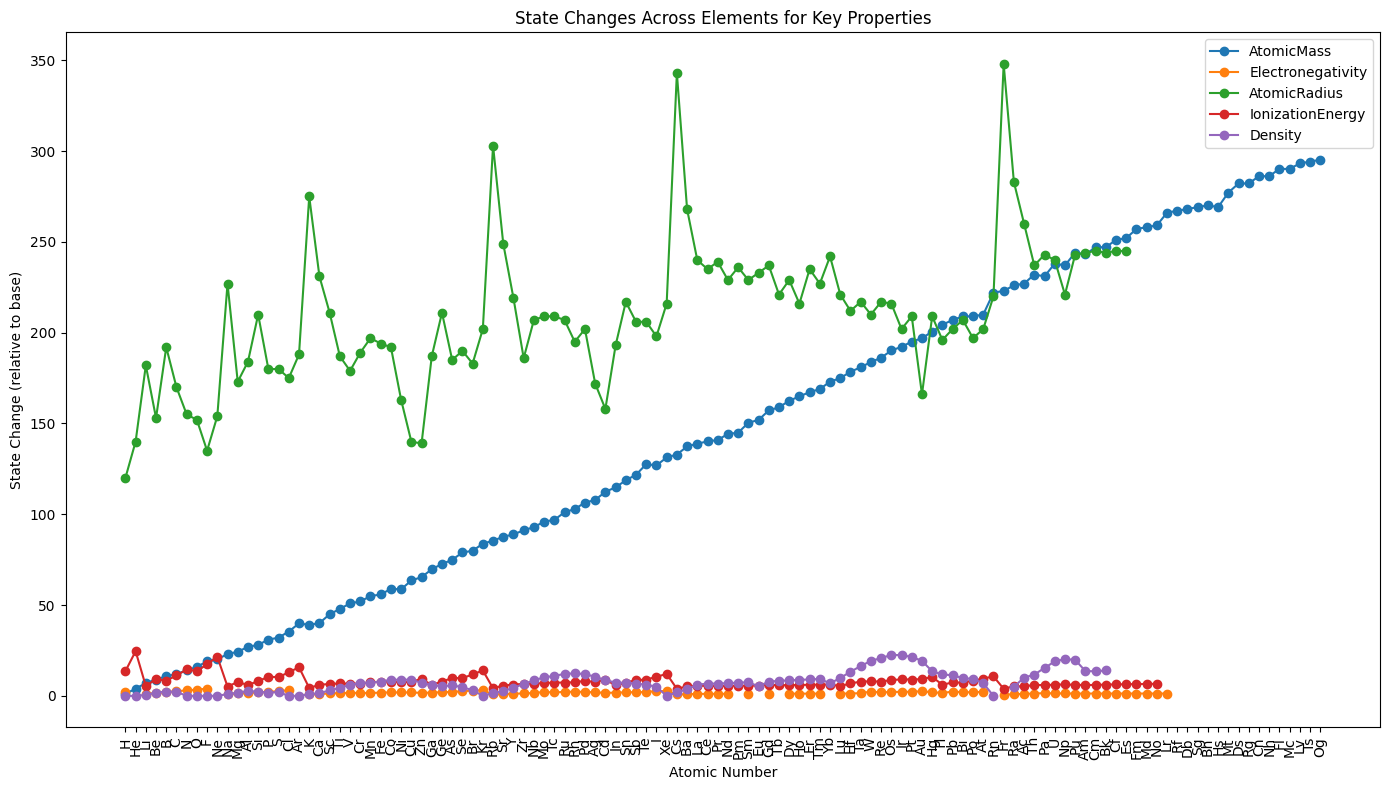

In [7]:
import matplotlib.pyplot as plt

# Extract relevant data for visualization: symbols and atomic numbers
symbols = list(G.nodes)
atomic_numbers = list(range(1, len(symbols) + 1))  # Assuming sequential atomic numbers

# Define properties to visualize and retrieve their state change values
properties = ["AtomicMass", "Electronegativity", "AtomicRadius", "IonizationEnergy", "Density"]
state_changes = {prop: [G.nodes[element].get(prop, None) for element in symbols] for prop in properties}

# Plot state changes for each property across elements
plt.figure(figsize=(14, 8))

for prop in properties:
    plt.plot(atomic_numbers, state_changes[prop], label=prop, marker='o', linestyle='-')

# Customize plot for readability
plt.xlabel("Atomic Number")
plt.ylabel("State Change (relative to base)")
plt.title("State Changes Across Elements for Key Properties")
plt.legend()
plt.xticks(atomic_numbers, symbols, rotation=90)
plt.tight_layout()
plt.show()

In [8]:
# Load the compact cube file
with open(compact_cube_file_path, "r") as file:
    compact_cube_data = json.load(file)

# Extract schema headers and element data
schema_headers = compact_cube_data["Schema"]["Headers"]
element_data = compact_cube_data["Elements"]

# Convert compact data into a DataFrame for easier analysis
import pandas as pd

# Parse each element's comma-separated values according to the schema
parsed_data = {
    symbol: dict(zip(schema_headers, values.split(","))) for symbol, values in element_data.items()
}

# Convert parsed data to a DataFrame
element_df = pd.DataFrame.from_dict(parsed_data, orient="index")

# Convert numeric columns to floats for analysis (where applicable)
numeric_columns = ["AtomicMass", "Electronegativity", "AtomicRadius", "IonizationEnergy", 
                   "ElectronAffinity", "MeltingPoint", "BoilingPoint", "Density"]
for col in numeric_columns:
    element_df[col] = pd.to_numeric(element_df[col], errors="coerce")

# Display the DataFrame to inspect and verify structure
element_df.head()

AtomicMass  Electronegativity  AtomicRadius  IonizationEnergy  \
H     1.008000               2.20         120.0            13.598   
He    4.002600                NaN         140.0            24.587   
Li    7.000000               0.98         182.0             5.392   
Be    9.012183               1.57         153.0             9.323   
B    10.810000               2.04         192.0             8.298   

    ElectronAffinity  MeltingPoint  BoilingPoint   Density     Symbol  \
H              0.754         13.81         20.28  0.000090   Hydrogen   
He               NaN          0.95          4.22  0.000179     Helium   
Li             0.618        453.65       1615.00  0.534000    Lithium   
Be               NaN       1560.00       2744.00  1.850000  Beryllium   
B              0.277       2348.00       4273.00  2.370000      Boron   

           Name ElectronConfiguration       OxidationStates GroupBlock  \
H           1s1                    +1                    -1   Nonmetal   
He          1s2                     0             Noble gas        Gas   
Li      [He]2s1                    +1          Alkali metal      Solid   
Be      [He]2s2                    +2  Alkaline earth metal      Solid   
B   [He]2s2 2p1                    +3             Metalloid      Solid   

   StandardState YearDiscovered Period Group  
H            Gas           1766            1  
He          1868                     1    18  
Li          1817                     2     1  
Be          1798                     2     2  
B           1808                     2    13

In [9]:
# Inspect unique values in the "Period" column to identify inconsistencies
element_df["Period"].unique()

array(['', '1', '2', 'Ancient', ' -1', '3', '1854', '1669', 'Gas', '4',
       '1791', 'Solid', '1797', '1817', '1826', '5', '1937', '1782',
       '1925', 'Halogen', '1967', 'Transition metal', ' 2', ' 1',
       'Expected to be a Solid', '1996', 'Post-transition metal', '2000'],
      dtype=object)

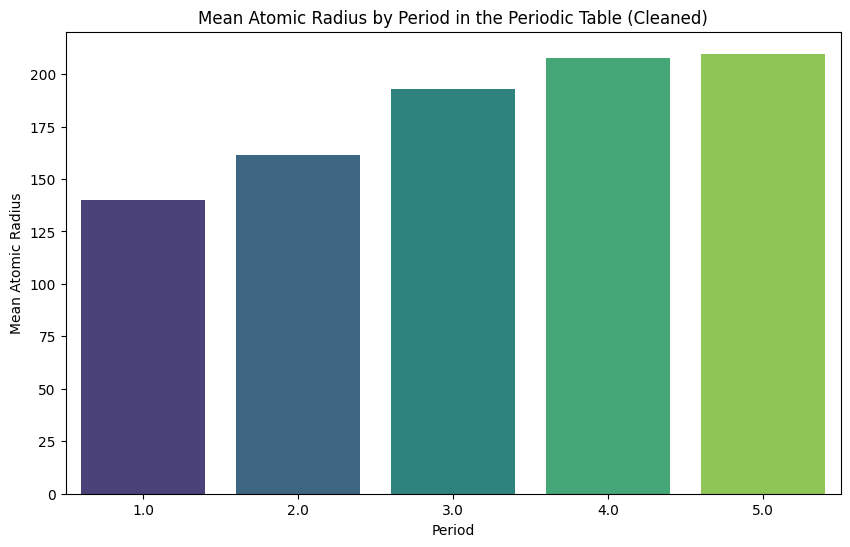

In [10]:
# Clean the Period column by keeping only numeric periods (1 through 7) and converting them to integers
element_df["Period"] = pd.to_numeric(element_df["Period"], errors="coerce")
element_df = element_df[element_df["Period"].between(1, 7, inclusive="both")]

# Recalculate the mean Atomic Radius by Period after cleaning
periodic_trends = element_df.groupby("Period")["AtomicRadius"].mean().dropna()


# Re-import seaborn in case of import issues and re-plot the cleaned mean Atomic Radius by Period
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the cleaned mean Atomic Radius by Period
plt.figure(figsize=(10, 6))
sns.barplot(x=periodic_trends.index, y=periodic_trends.values, palette="viridis")
plt.xlabel("Period")
plt.ylabel("Mean Atomic Radius")
plt.title("Mean Atomic Radius by Period in the Periodic Table (Cleaned)")
plt.show()

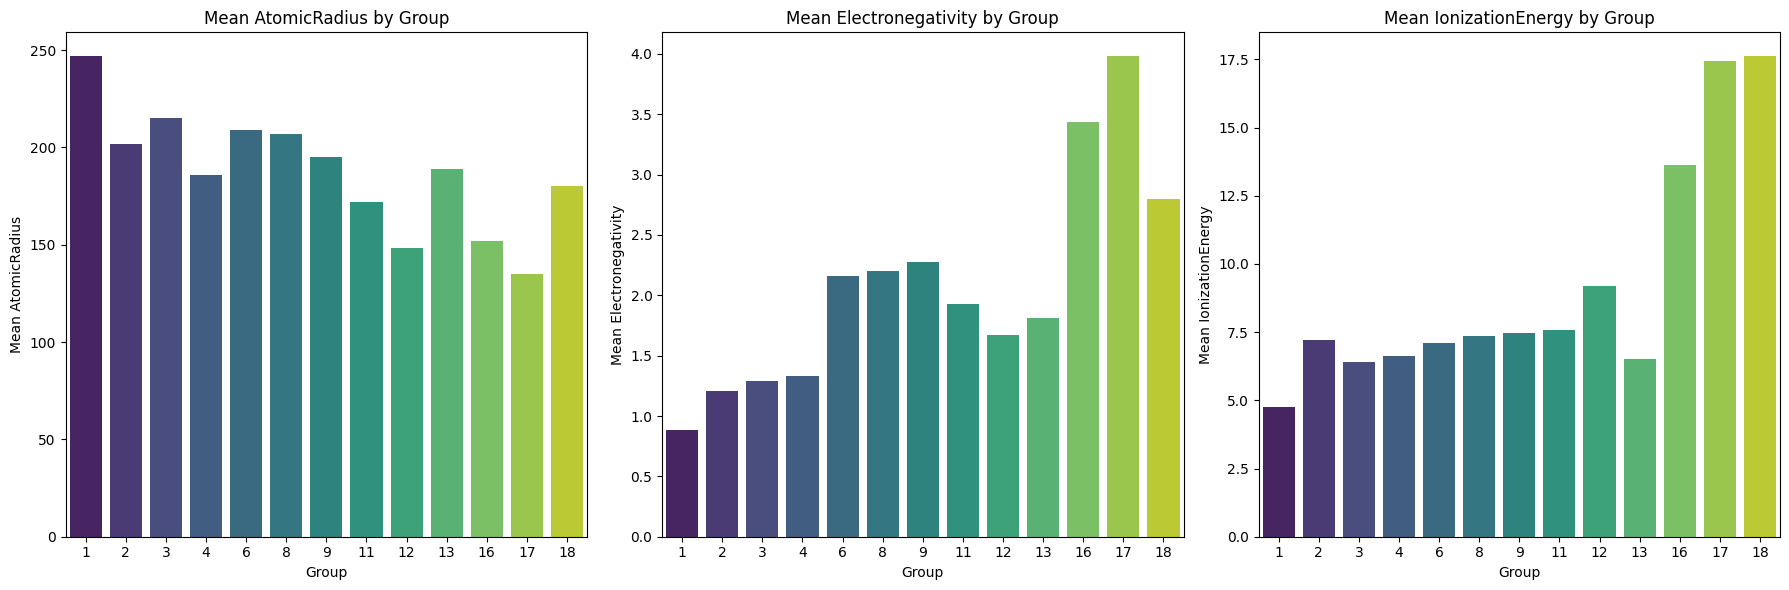

In [11]:
# Group Analysis: Calculate mean values for key properties by Group and visualize them
# Select key properties for analysis
key_properties = ["AtomicRadius", "Electronegativity", "IonizationEnergy"]

# Initialize a dictionary to hold the mean values by group for each property
group_analysis_results = {prop: element_df.groupby("Group")[prop].mean().dropna() for prop in key_properties}

# Plot each property by group as a bar chart
fig, axes = plt.subplots(1, len(key_properties), figsize=(18, 6), sharey=False)

for i, prop in enumerate(key_properties):
    sns.barplot(x=group_analysis_results[prop].index.astype(int), y=group_analysis_results[prop].values, ax=axes[i], palette="viridis")
    axes[i].set_title(f"Mean {prop} by Group")
    axes[i].set_xlabel("Group")
    axes[i].set_ylabel(f"Mean {prop}")

plt.tight_layout()
plt.show()

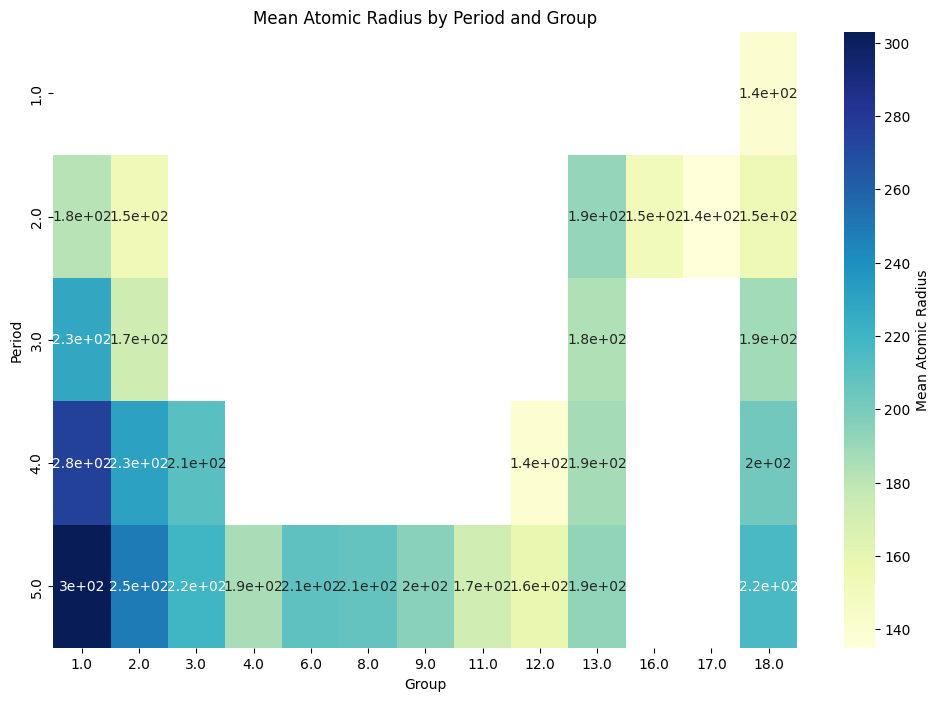

In [12]:
# Comparison of Trends by Group and Period using a heatmap for Atomic Radius as an example
# We will pivot the data to create a matrix of Atomic Radius values by Group and Period

# First, ensure "Period" and "Group" are numeric for correct plotting
element_df["Period"] = pd.to_numeric(element_df["Period"], errors="coerce")
element_df["Group"] = pd.to_numeric(element_df["Group"], errors="coerce")

# Pivot the data to show the mean Atomic Radius by Period and Group
atomic_radius_matrix = element_df.pivot_table(values="AtomicRadius", index="Period", columns="Group", aggfunc="mean")

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(atomic_radius_matrix, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mean Atomic Radius'})
plt.xlabel("Group")
plt.ylabel("Period")
plt.title("Mean Atomic Radius by Period and Group")
plt.show()

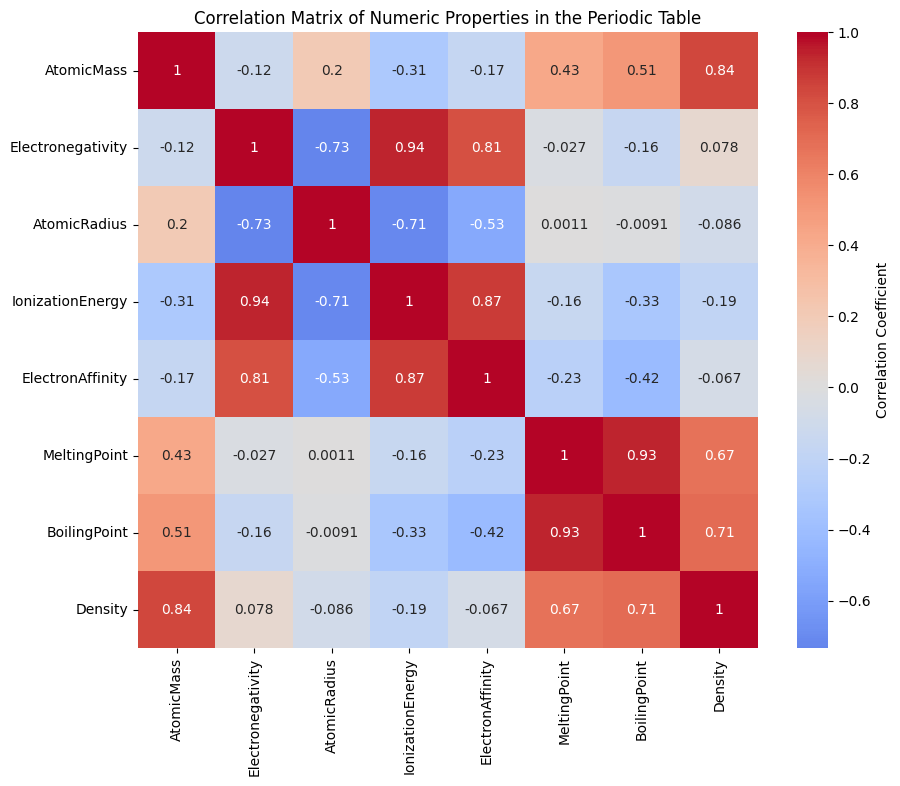

In [13]:
# Correlation Analysis: Calculate and visualize the correlations between numeric properties
# Filter the DataFrame to include only numeric properties for correlation
numeric_df = element_df[numeric_columns].dropna()

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix of Numeric Properties in the Periodic Table")
plt.show()

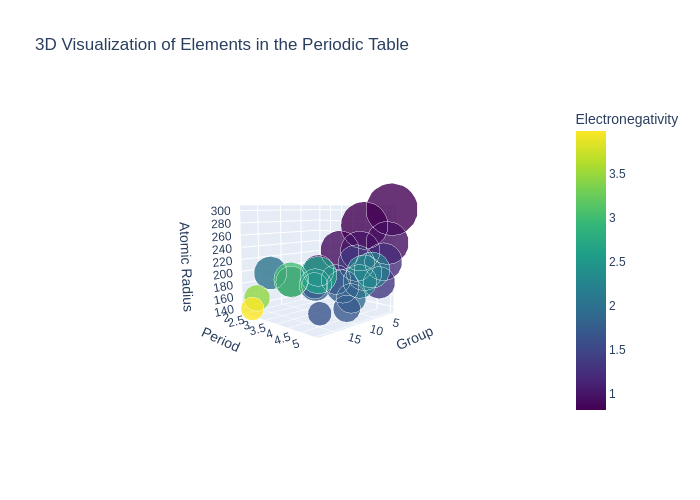

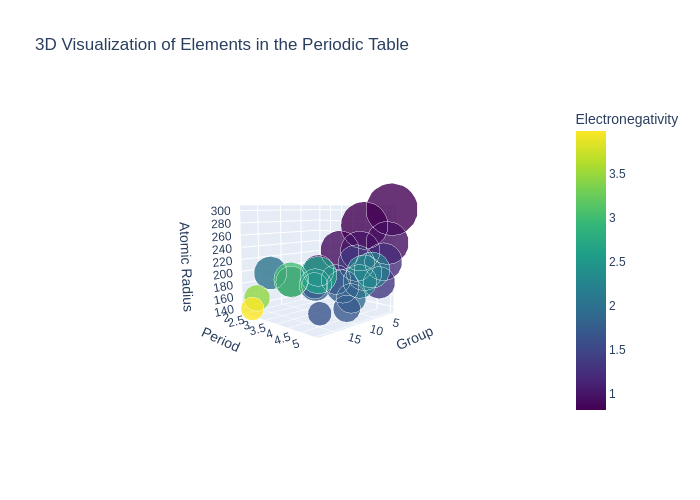

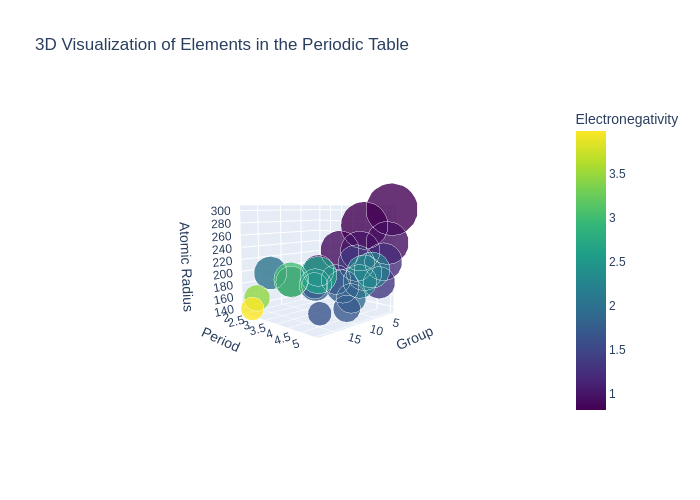

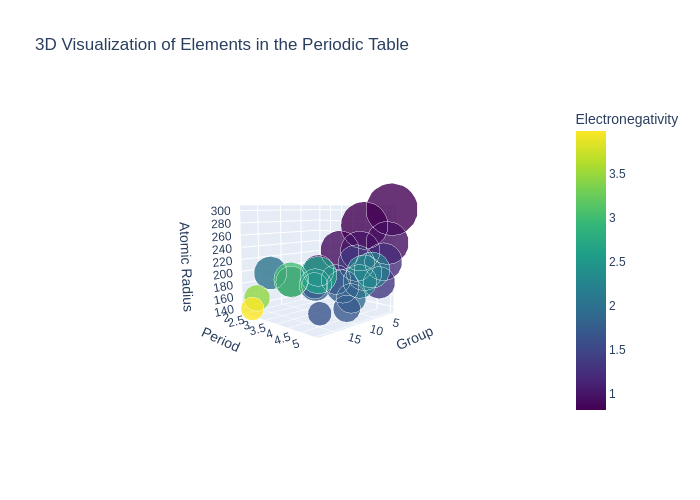

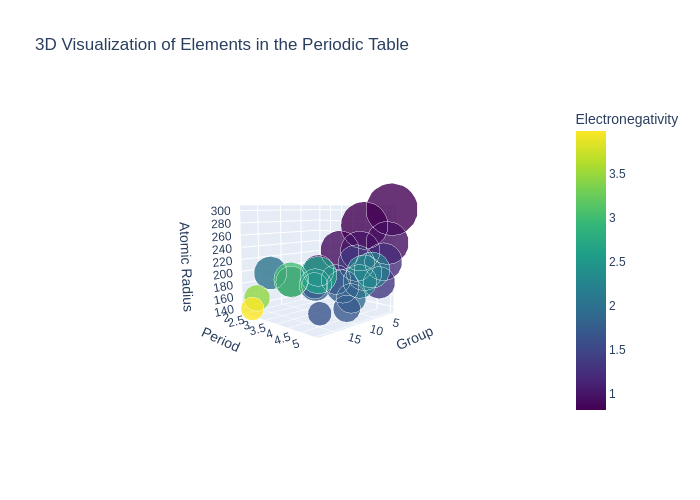

In [14]:
import plotly.graph_objects as go
import pandas as pd

# Assuming `element_df` is your DataFrame containing periodic table data
# Make sure to drop any missing Group or Period values for this visualization
visual_df = element_df.dropna(subset=["Group", "Period", "AtomicRadius", "Electronegativity"])

# Set up the 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=visual_df["Group"].astype(int),  # X-axis as Group
        y=visual_df["Period"].astype(int),  # Y-axis as Period
        z=visual_df["AtomicRadius"],       # Z-axis as Atomic Radius for vertical positioning
        text=visual_df["Symbol"],          # Element symbols as hover text
        mode='markers',
        marker=dict(
            size=visual_df["AtomicRadius"] / 5,  # Size based on Atomic Radius, scaled down for clarity
            color=visual_df["Electronegativity"],  # Color based on Electronegativity
            colorscale="Viridis",
            colorbar=dict(title="Electronegativity"),
            opacity=0.8
        )
    )
])

# Update layout to mimic the structure of the periodic table
fig.update_layout(
    scene=dict(
        xaxis=dict(title="Group"),
        yaxis=dict(title="Period"),
        zaxis=dict(title="Atomic Radius"),
    ),
    title="3D Visualization of Elements in the Periodic Table",
)

# Save snapshots of the 3D plot at different angles
angles = [0, 45, 90, 135, 180]  # Define rotation angles for snapshots
for angle in angles:
    # Update camera angle
    fig.update_layout(scene_camera=dict(eye=dict(x=2.5, y=2.5, z=0.5)))
    # Save as image
    fig.write_image(f"PeriodicTable_3D_Angle_{angle}.png")

# Display snapshots by loading them as static images
from IPython.display import Image, display

for angle in angles:
    display(Image(filename=f"PeriodicTable_3D_Angle_{angle}.png"))

In [15]:
from sympy import isprime

# Extended Cube4D structure to analyze perfect numbers with deeper 3-based transformations
class Cube4DPerfectNumberAnalyzer:
    def __init__(self, limit):
        self.limit = limit
        self.cube = {}

    def add_to_cube(self, p, mersenne_prime_candidate, perfect_number):
        # Transformation steps with 3-based division and re-scaling
        subtract_1 = perfect_number - 1
        divide_by_3_once = subtract_1 // 3
        divide_by_3_twice = divide_by_3_once // 3
        re_scaled = divide_by_3_twice * 3

        # Calculate scaling factors relative to each transformation
        scaling_factors = {
            "subtract_1_to_divide_by_3_once": divide_by_3_once / subtract_1 if subtract_1 != 0 else None,
            "divide_by_3_once_to_divide_by_3_twice": divide_by_3_twice / divide_by_3_once if divide_by_3_once != 0 else None
        }

        # Print formatted output for clarity
        print(f"Perfect Number: {perfect_number}")
        print(f"Prime Exponent (p): {p}")
        print(f"Mersenne Prime: {mersenne_prime_candidate}")
        print("Calculations:")
        print(f"  Subtract 1: {perfect_number} - 1 = {subtract_1}")
        print(f"  Divide by 3 (Once): {subtract_1} // 3 = {divide_by_3_once}")
        print(f"  Divide by 3 (Twice): {divide_by_3_once} // 3 = {divide_by_3_twice}")
        print(f"  Re-scale (Multiply by 3): {divide_by_3_twice} * 3 = {re_scaled}")
        print("Scaling Factors:")
        print(f"  Scaling Factor (Subtract 1 to Divide by 3 Once): {scaling_factors['subtract_1_to_divide_by_3_once']:.3f}")
        print(f"  Scaling Factor (Divide by 3 Once to Divide by 3 Twice): {scaling_factors['divide_by_3_once_to_divide_by_3_twice']:.3f}")
        print("------")

    def find_perfect_numbers(self):
        perfect_numbers = []

        # Iterate over possible prime exponents to generate larger perfect numbers
        for p in range(2, self.limit):
            if isprime(p):
                mersenne_prime_candidate = 2**p - 1
                if isprime(mersenne_prime_candidate):
                    perfect_number = 2**(p-1) * mersenne_prime_candidate
                    self.add_to_cube(p, mersenne_prime_candidate, perfect_number)
                    perfect_numbers.append(perfect_number)

        return perfect_numbers

# Usage
limit = 150  # Set a high limit to test even larger perfect numbers
analyzer = Cube4DPerfectNumberAnalyzer(limit)
perfect_numbers = analyzer.find_perfect_numbers()

Perfect Number: 6
Prime Exponent (p): 2
Mersenne Prime: 3
Calculations:
  Subtract 1: 6 - 1 = 5
  Divide by 3 (Once): 5 // 3 = 1
  Divide by 3 (Twice): 1 // 3 = 0
  Re-scale (Multiply by 3): 0 * 3 = 0
Scaling Factors:
  Scaling Factor (Subtract 1 to Divide by 3 Once): 0.200
  Scaling Factor (Divide by 3 Once to Divide by 3 Twice): 0.000
------
Perfect Number: 28
Prime Exponent (p): 3
Mersenne Prime: 7
Calculations:
  Subtract 1: 28 - 1 = 27
  Divide by 3 (Once): 27 // 3 = 9
  Divide by 3 (Twice): 9 // 3 = 3
  Re-scale (Multiply by 3): 3 * 3 = 9
Scaling Factors:
  Scaling Factor (Subtract 1 to Divide by 3 Once): 0.333
  Scaling Factor (Divide by 3 Once to Divide by 3 Twice): 0.333
------
Perfect Number: 496
Prime Exponent (p): 5
Mersenne Prime: 31
Calculations:
  Subtract 1: 496 - 1 = 495
  Divide by 3 (Once): 495 // 3 = 165
  Divide by 3 (Twice): 165 // 3 = 55
  Re-scale (Multiply by 3): 55 * 3 = 165
Scaling Factors:
  Scaling Factor (Subtract 1 to Divide by 3 Once): 0.333
  Scaling Fa

In [16]:
import plotly.graph_objects as go
import pandas as pd

# Assuming `element_df` is your DataFrame containing periodic table data
# Filter data for rows where Group and Period are numeric
visual_df = element_df.dropna(subset=["Group", "Period", "AtomicRadius", "Electronegativity"])

# Set up the 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=visual_df["Group"].astype(int),  # X-axis as Group
        y=visual_df["Period"].astype(int),  # Y-axis as Period
        z=visual_df["AtomicRadius"],       # Z-axis as Atomic Radius for vertical positioning
        text=visual_df["Symbol"],          # Element symbols as hover text
        mode='markers',
        marker=dict(
            size=visual_df["AtomicRadius"] / 5,  # Size based on Atomic Radius, scaled down for clarity
            color=visual_df["Electronegativity"],  # Color based on Electronegativity
            colorscale="Viridis",
            colorbar=dict(title="Electronegativity"),
            opacity=0.8
        )
    )
])

# Update layout to mimic the structure of the periodic table
fig.update_layout(
    scene=dict(
        xaxis=dict(title="Group"),
        yaxis=dict(title="Period"),
        zaxis=dict(title="Atomic Radius"),
    ),
    title="3D Visualization of Elements in the Periodic Table",
)

# Define several camera perspectives
camera_angles = [
    dict(eye=dict(x=1.5, y=1.5, z=0.5)),  # Diagonal view
    dict(eye=dict(x=2, y=0, z=0.5)),      # Side view
    dict(eye=dict(x=0, y=2, z=0.5)),      # Front view
    dict(eye=dict(x=2.5, y=2.5, z=1)),    # Elevated diagonal view
    dict(eye=dict(x=-1.5, y=-1.5, z=0.5)) # Opposite diagonal
]

# Loop through each perspective and display the plot with updated camera position
for i, camera in enumerate(camera_angles):
    fig.update_layout(scene_camera=camera)
    fig.show()